# Disklab - RADMC-3D

Example notebook showing how to build a `RADMC-3D` model out of a `DISKLAB` disk.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

import glob

import disklab
from disklab.natconst import *
from disklab import radmc3d

plt.style.use(['seaborn-dark', {'figure.dpi': 150}])

# Opacity

We calculate opacities from scratch using the dsharp opacity module. Here we can pick [Draine 2003 optical constants](https://www.astro.princeton.edu/~draine/dust/dust.diel.html) or the [DSHARP optical constants](https://doi.org/10.3847/2041-8213/aaf743).

In [2]:
# decide which optical constants to use

opac_name = 'DSHARP' # choices: DSHARP, Draine

# define wave length and particle size grids

lam   = np.logspace(-5, 0, 200)
a     = np.logspace(-5, 0, 150)

In [3]:
import dsharp_opac as opacity

# define optical constants and material density

if opac_name == 'Draine':
    fname = 'dustkappa_draine2003_astrosilicates'
    diel_const = opacity.diel_draine2003('astrosilicates')
    rho_s = 3.5
elif opac_name == 'DSHARP':
    fname = 'dustkappa_default'
    diel_const, rho_s = opacity.get_dsharp_mix()
    diel_const.extrapol

# call the Mie calculation & store the opacity in a npz file

opac_dict = opacity.get_opacities(a, lam, rho_s=rho_s, diel_const=diel_const, extrapolate_large_grains=True)
opacity.write_disklab_opacity(fname, opac_dict)

Please cite Warren & Brandt (2008) when using these optical constants
Please cite Draine 2003 when using these optical constants
Reading opacities from troilitek
Please cite Henning & Stognienko (1996) when using these optical constants
Reading opacities from organicsk
Please cite Henning & Stognienko (1996) when using these optical constants
| material                            | volume fractions | mass fractions |
|-------------------------------------|------------------|----------------|
| Water Ice (Warren & Brandt 2008)    | 0.3642           | 0.2            |
| Astronomical Silicates (Draine 2003)| 0.167            | 0.329          |
| Troilite (Henning)                  | 0.02578          | 0.07434        |
| Organics (Henning)                  | 0.443            | 0.3966         |
Mie ... Done!


# 1D model
We start out with a 1D disk model. First set parameters:

In [4]:
mstar      = 2.04 * MS
lstar      = 10.**1.23 * LS
mdisk      = 0.06 * MS
flang      = 0.05
zrmax      = 1.0
nr         = 300
rin        = 1 * au
r_c        = 120 * au
rout       = 500 * au
alpha      = 1e-3
d2g        = 0.01

opac_params = ['dustcomponents', {'method': 'simplemixing'}]

Set up the model

In [5]:
d = disklab.DiskRadialModel(mstar=mstar, lstar=lstar, mdisk=mdisk, nr=nr, alpha=alpha, rin=rin, rout=rout)
d.make_disk_from_simplified_lbp(10, r_c, 1)

Normalize the disk mass

In [6]:
d.compute_mass()
d.sigma = d.sigma/d.mass * mdisk
d.compute_rhomid_from_sigma()
d.compute_mass()

Add a planetary gap and some dust species

In [7]:
d.add_planet_gap(60 * au, 'kanagawa', mpl=Mju, smooth=3)

# add N dust species

ngrains = 4
agrains = np.logspace(-4, -1, ngrains)
size_distri = agrains**0.5
size_distri /= size_distri.sum()

# define dust colors

cols = [f'{0.2 + 0.6 * idust / (ngrains - 1)}' for idust in range(ngrains)][::-1]

for eps, agrain in zip(size_distri, agrains):
    d.add_dust(agrain=agrain, xigrain=rho_s, dtg=d2g * eps)

In [8]:
# load the opacity from the previously calculated opacity table

for dust in d.dust:
    #dust.grain.load_standard_opacity('draine2003', 'astrosilicates', verbose=True)
    dust.grain.read_opacity(fname + '.npz')
    
# compute the mean opacities
    
d.meanopacitymodel = opac_params
d.compute_mean_opacity()

Plot dust and gas surface densities of the model

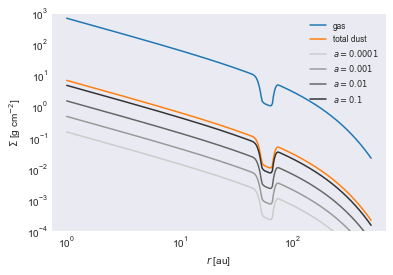

In [9]:
def plot_surface_densities(d):
    ngrains = len(d.dust)
    sig_d = np.sum([dust.sigma for dust in d.dust], 0)

    f, ax = plt.subplots()
    ax.loglog(d.r / AU, d.sigma, label='gas')
    ax.loglog(d.r / AU, sig_d, label='total dust')

    for col, dust in zip(cols, d.dust):
        ax.loglog(d.r / AU, dust.sigma, c=col, label=f'$a = {dust.grain.agrain:.2g}$')
    ax.legend(fontsize='small')
    ax.set_xlabel('$r$ [au]')
    ax.set_ylabel('$\Sigma$ [g cm$^{-2}$]');
    ax.set_ylim(1e-4, 1e3);
    
plot_surface_densities(d)

To make it a little more interesting, we let the dust evolve for some time

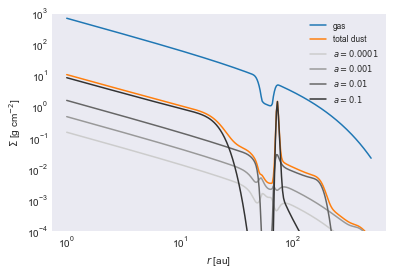

In [10]:
for i in range(100):
    for dust in d.dust:
        dust.compute_dust_radial_drift_next_timestep(1000 * year)

plot_surface_densities(d)

Plot the opacities of the species

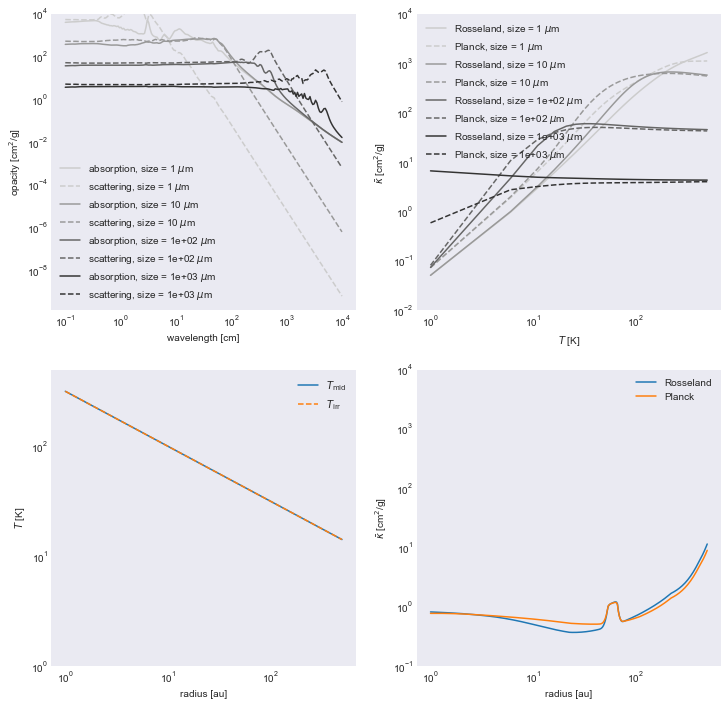

In [11]:
f, axs = plt.subplots(2,2, figsize=(12,12))
axs=axs.ravel()

# wavelength dependent opacities

for col, dust in zip(cols, d.dust):
    axs[0].loglog(dust.grain.opac_lammic, dust.grain.opac_kabs,
                '-', c=col, label='absorption, size = {:.2g} $\mu$m'.format(dust.grain.agrain * 1e4))
    axs[0].loglog(dust.grain.opac_lammic, dust.grain.opac_ksca, 
                '--', c=col, label='scattering, size = {:.2g} $\mu$m'.format(dust.grain.agrain * 1e4))
axs[0].legend()
axs[0].set_ylim(top=1e4);
axs[0].set_xlabel('wavelength [cm]')
axs[0].set_ylabel('opacity [cm$^2$/g]');

# mean opacities

T = np.linspace(1,500,100)

for col, dust in zip(cols, d.dust):
    axs[1].loglog(T, dust.grain.rosselandmean(T), '-', c=col, label='Rosseland, size = {:.2g} $\mu$m'.format(dust.grain.agrain * 1e4))
    axs[1].loglog(T, dust.grain.planckmean(T), '--', c=col, label='Planck, size = {:.2g} $\mu$m'.format(dust.grain.agrain * 1e4))
axs[1].set_ylim(1e-2,1e4)
axs[1].set_xlabel('$T$ [K]')
axs[1].set_ylabel(r'$\bar \kappa$ [cm$^2$/g]')
axs[1].legend();

# temperature

axs[2].loglog(d.r/au,d.tmid,  '-',  label='$T_\mathrm{mid}$')
axs[2].loglog(d.r/au,d.tirr,  '--', label='$T_\mathrm{irr}$')
axs[2].set_ylim(1e0,500)
axs[2].set_ylabel('$T$ [K]')
axs[2].set_xlabel('radius [au]')
axs[2].legend();

# mean opacity in disk

axs[3].loglog(d.r/au, d.mean_opacity_rosseland, label='Rosseland')
axs[3].loglog(d.r/au, d.mean_opacity_planck, label='Planck')
axs[3].set_ylim(1e-1,1e4)
axs[3].set_xlabel('radius [au]')
axs[3].set_ylabel(r'$\bar \kappa$ [cm$^2$/g]')
axs[3].legend();

Check the mid-plane dust-to-gas ratio

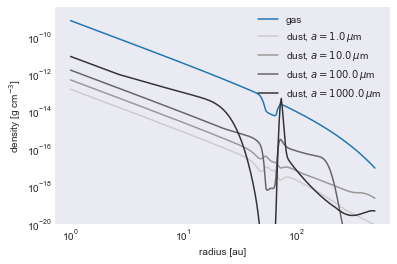

In [12]:
f, ax = plt.subplots()
ax.loglog(d.r / au, d.rhomid, label='gas')
for col, dust in zip(cols, d.dust):
    ax.loglog(d.r / au, dust.rhomid, c=col, label='dust, $a= {}\, \mu$m'.format(dust.grain.agrain*1e4))
ax.set_xlabel('radius [au]')
ax.set_ylabel('density [g cm$^{-3}$]')
ax.set_ylim(bottom=1e-20)
ax.legend();

## 2D model
Next we make a 2D disk model out of the 1D model. This should work with more complicated opacity as well. This works by using the mid-plane temperature of the 1D model and assuming it to be vertically isothermal. Furthermore, the dust is assumed to be well mixed with the gas.

In [13]:
disk2d = disklab.Disk2D(disk=d, zrmax=zrmax, meanopacitymodel=d.meanopacitymodel, nz=200)

Plot the vertical structure

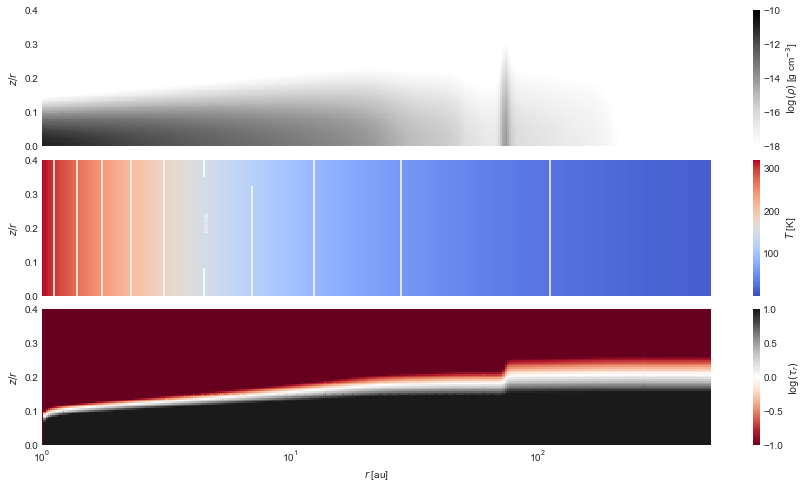

In [14]:
X0,Z0,rho0,T0,tau0,f = disklab.radmc3d.plot_vert_structure(disk2d)
plt.savefig('vertstruct1.pdf')

Update the dust density to settling-mixing equilibrium

In [15]:
for vert in disk2d.verts:
    vert.compute_rhogas_hydrostatic()
    for dust in vert.dust:
        dust.compute_settling_mixing_equilibrium()

Plot the vertical structure again to compare

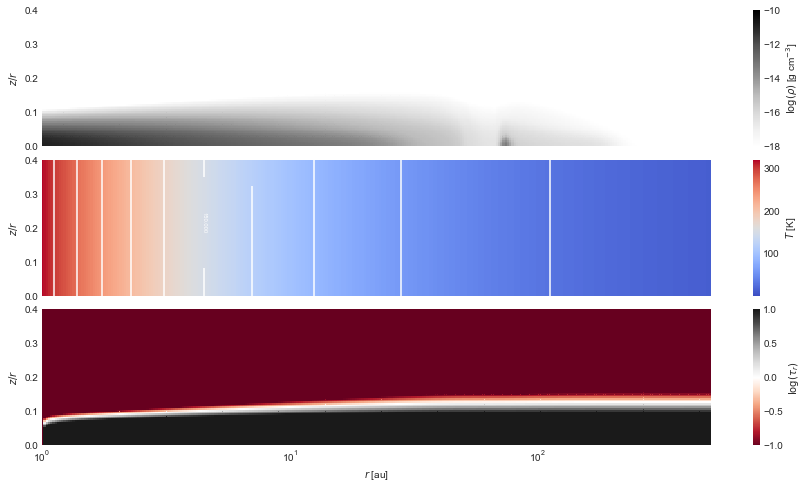

In [16]:
X0,Z0,rho0,T0,tau0,f = disklab.radmc3d.plot_vert_structure(disk2d)
plt.savefig('vertstruct2.pdf')

# 2D radiative diffusion

Calculate the 2D flux-limited diffusion temperature

In [17]:
for vert in disk2d.verts:
    vert.compute_mean_opacity()
    vert.iterate_vertical_structure()

In [18]:
%%time
maxiter = 3
rhokap = []
for iter in range(maxiter):
    for vert in disk2d.verts:
        vert.compute_mean_opacity()
    disk2d.radial_raytrace()
    disk2d.solve_2d_rad_diffusion(thist=True)
    for vert in disk2d.verts:
        vert.compute_rhogas_hydrostatic()

  Nr of iter linear solver: 2184. Flux limiter iteration:  0. Error = 23.383333031886934
  Nr of iter linear solver: 1880. Flux limiter iteration:  1. Error = 0.8376154851527197
  Nr of iter linear solver: 1824. Flux limiter iteration:  2. Error = 0.6816001981559403
  Nr of iter linear solver: 1820. Flux limiter iteration:  3. Error = 0.5738977447022581
  Nr of iter linear solver: 1882. Flux limiter iteration:  4. Error = 0.1828416414992926
  Nr of iter linear solver: 1885. Flux limiter iteration:  5. Error = 0.08050751417641844
  Nr of iter linear solver: 1826. Flux limiter iteration:  6. Error = 0.045103070037457504
  Nr of iter linear solver: 1866. Flux limiter iteration:  7. Error = 0.025776831153142332
  Nr of iter linear solver: 1831. Flux limiter iteration:  8. Error = 0.02190105691966926
  Nr of iter linear solver: 1813. Flux limiter iteration:  9. Error = 0.018848293762144808
  Nr of iter linear solver: 1862. Flux limiter iteration: 10. Error = 0.01614048637537724
  Nr of iter

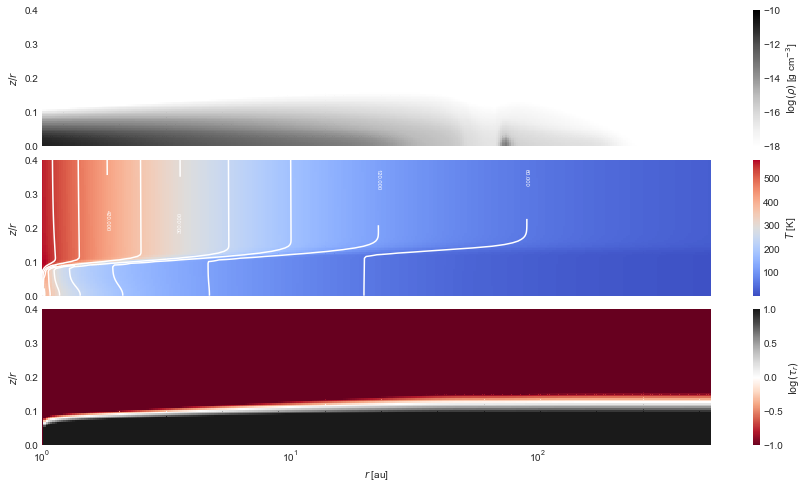

In [19]:
X0,Z0,rho0,T0,tau0,f = disklab.radmc3d.plot_vert_structure(disk2d)
plt.savefig('vertstruct_fld.pdf')

## RADMC3D Setup

So far we were working in cylindrical coordinates, now we need to create spherical ones and interpolate onto those

In [20]:
rmcd = disklab.radmc3d.get_radmc3d_arrays(disk2d, showplots=False)

Assign the radmc3d data

In [21]:
nphi   = rmcd['nphi']
ri     = rmcd['ri']
thetai = rmcd['thetai']
phii   = rmcd['phii']
nr     = rmcd['nr']
nth    = rmcd['nth']
nphi   = rmcd['nphi']
rho    = rmcd['rho']

Define the wavelength grid for the radiative transfer

In [22]:
nlam = 200
lam = np.logspace(-5,0,nlam)
lam_mic = lam * 1e4

Write the `RADMC3D` input

In [23]:
!rm dustkappa_*.inp

In [24]:
radmc3d.write_stars_input(d,lam_mic)
radmc3d.write_grid(ri, thetai, phii)
radmc3d.write_dust_density(rho)
radmc3d.write_wavelength_micron(lam_mic)
radmc3d.write_opacity(disk2d)
radmc3d.write_radmc3d_input({'scattering_mode': 2, 'scattering_mode_max': 2, 'nphot': 10000000})

# Running RADMC-3D

In [25]:
%%time
radmc3d.radmc3d('mctherm setthreads 4')

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D reincarnation of the 2-D RADMC code
>>>                   (c) 2010/2015 Cornelis Dullemond
>>>   
>>>    ************* NOTE: THIS IS STILL A BETA VERSION ***************
>>>    ****** Some modes/capabilities are not yet ready/mature ********
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>         the RADMC-3D mailing list by sending an email to me:
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    =========================

Make images

In [27]:
%%time
lam_obs = 0.125
rd = 150 * au
radmc3d.radmc3d(f'image npix 500 lambdarange 1.65 {lam_obs * 1e4} nlam 2 incl 0 posang 0 sizeau {2*rd/au} nostar secondorder')

>>>   
>>>    ================================================================
>>>         WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER
>>>   
>>>           This is the 3-D reincarnation of the 2-D RADMC code
>>>                   (c) 2010/2015 Cornelis Dullemond
>>>   
>>>    ************* NOTE: THIS IS STILL A BETA VERSION ***************
>>>    ****** Some modes/capabilities are not yet ready/mature ********
>>>   
>>>          Please feel free to ask questions. Also please report
>>>           bugs and/or suspicious behavior without hestitation.
>>>         The reliability of this code depends on your vigilance!
>>>   
>>>      To keep up-to-date with bug-alarms and bugfixes, register to
>>>         the RADMC-3D mailing list by sending an email to me:
>>>                       dullemond@uni-heidelberg.de
>>>   
>>>                 Please visit the RADMC-3D home page at
>>>     http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/
>>>    =========================

# Reading RADMC-3D

Read the image data

In [28]:
im = radmc3d.read_image()

Plot the image

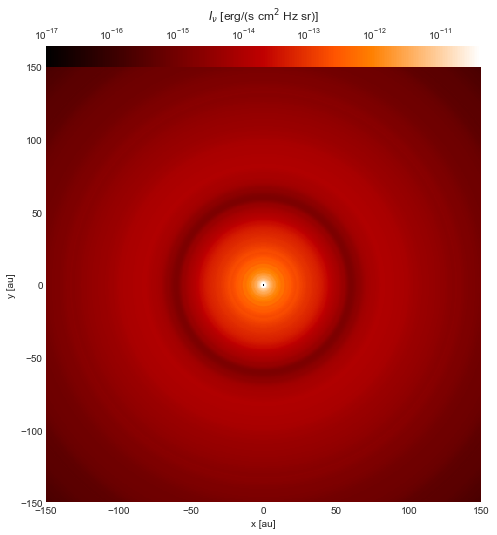

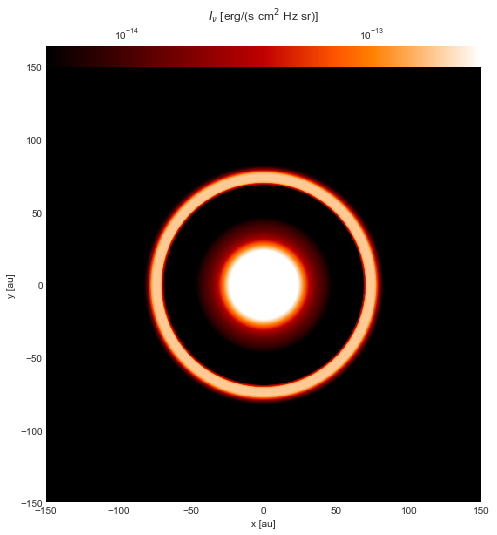

In [29]:
from matplotlib.colors import LogNorm

vmin_arr = [1e-17, 4.7e-15]

for i in range(im.image.shape[-1]):
    f, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect(1)
    vmax = 0.1 * im.image[..., i].max()
    vmin = vmin_arr[i]
    cc = ax.pcolormesh(im.x / au, im.y / au, im.image[...,i], norm=LogNorm(), vmin=vmin, vmax=vmax, cmap=plt.cm.gist_heat, rasterized=True)

    pos = ax.get_position()
    cb = plt.colorbar(cc, orientation='horizontal')
    cb.ax.set_position([pos.x0, pos.y1, pos.width, 0.05 * pos.height])
    ax.set_position([pos.x0, pos.y0,pos.width, pos.height])
    cb.ax.xaxis.tick_top()
    cb.ax.set_title(r'$I_\nu$ [erg/(s cm$^2$ Hz sr)]')
    ax.set_xlabel('x [au]')
    ax.set_ylabel('y [au]')
    f.savefig('image_1250micron.pdf', transparent=True)

Plot the total dust density used in RADMC3D

In [ ]:
grid = radmc3d.read_amr_grid()
data = radmc3d.read_data(dtemp=False, ddens=True)

R,T = np.meshgrid(grid.ri,grid.thetai)
X,Y = R * np.sin(T), R * np.cos(T)
plt.pcolormesh(X / au,Y / au, np.log10(data.rho[:, :, 0, :].sum(-1).T + 1e-25))
plt.xlim(10, 100)
plt.ylim(-10, 10)

Read data structure and interpolate RADMC3D temperature on vertical grid

In [30]:
grid = radmc3d.read_amr_grid()
data = radmc3d.read_data(dtemp=True, ddens=True)

nspec = len(glob.glob('dustkappa_*.inp'))

# Interpolate temperature on same grid

X_c = grid.r[:, None] * np.cos(np.pi / 2 - grid.thetai[:0:-1])[None, :]
Y_c = grid.r[:, None] * np.sin(np.pi / 2 - grid.thetai[:0:-1])[None, :]

points = np.array(list(zip(np.log10(X_c).flatten(),Y_c.flatten())))
values = np.log10(data.rho[:,::-1,0,0].flatten())
newpoints = np.array(list(zip(np.log10(X0.flatten()),Z0.flatten())))

rho_sph = 10.**griddata(points,values,newpoints,fill_value=-100, rescale=True).reshape(*X0.shape)
T2 = griddata(points,data.temp[:,::-1,0,0].flatten(),newpoints, rescale=True).reshape(*X0.shape)

Plot temperatures in comparison

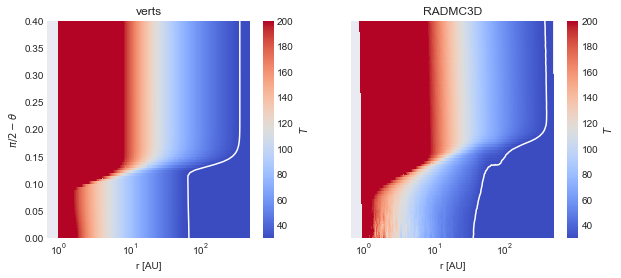

In [31]:
f,axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,4))

vmin = 30
vmax = 200

c2 = axs[0].pcolormesh(X0/au, Z0/X0, T0,cmap='coolwarm',vmin=vmin,vmax=vmax)
cc = axs[0].contour(X0/au, Z0/X0, T0, [30])
cb = plt.colorbar(c2,ax=axs[0])
cb.set_label(r'$T$')
axs[0].set_title('verts')

c1 = axs[1].pcolormesh(X_c/au, Y_c/X_c, data.temp[:,::-1,0,0],cmap='coolwarm',vmin=vmin,vmax=vmax)
cc = axs[1].contour(X_c/au, Y_c/X_c, data.temp[:,::-1,0,0], [30])
cb = plt.colorbar(c1,ax=axs[1])
cb.set_label(r'$T$')
axs[1].set_title('RADMC3D')


for ax in axs:
    ax.set_xlabel('r [AU]')
    ax.set_xscale('log')
    ax.set_ylim(0,0.4)
axs[0].set_ylabel(r'$\pi/2-\theta$');

Compare the different mid-plane temperatures

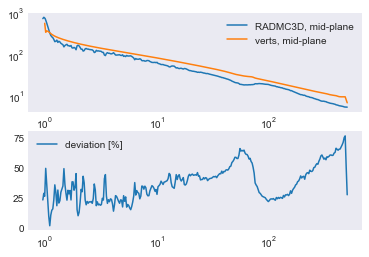

In [32]:
f,ax = plt.subplots(2, 1)
ax[0].loglog(X_c[:,0]/au,data.temp[:,-5:,0,0].mean(-1),label='RADMC3D, mid-plane')
ax[0].loglog(X0[:,0]/au,T0[:,0],label='verts, mid-plane')
ax[0].legend();
ax[1].semilogx(X_c[:,0]/au,np.abs(np.interp(X_c[:,0],X0[:,0],T0[:,0])/data.temp[:,-5:,0,0].mean(-1)-1)*100,label='deviation [%]')
ax[1].legend();